# Autoencoder

## Motivation
We use train an autoencoder using all of the EEG signals, use the trained autoencoder to augment the signals, and validate on the downstream task of seizure detection.

**Note: To run this notebook, it is highly recommended to use GPU.**

## I. Train an autoencoder
- Processing: Min-max scaling
- Encoder: Inception Nucleus: https://ieeexplore.ieee.org/document/9054725
- Decoder: Reverse process of the encoder
- Hyperparameters:
    - loss function: mse
    - optimizer: Adam
    - learning rate: 0.0001
    - epochs: 10
    - batch_size: 32
    - early stopping: 5 patience epochs after validation loss stops deacreasing.

### Model

In [ ]:
# Import necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, Conv1DTranspose, Dropout, Dense, Flatten

gpus = tf.config.list_physical_devices('GPU')
device = '/device:GPU:0' if gpus else '/device:CPU:0'
print(f"Using device: {device}")

Using device: /device:CPU:0


In [ ]:
# Model architecture

def InceptionNucleus(input_layer, filters, one_d_dropout_rate=0):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(one_d_dropout_rate)(x)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def InceptionNucleusTranspose(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1DTranspose(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_autoencoder(one_d_dropout_rate=0, two_d_dropout_rate=0):
    # Encoder
    inputs = Input(shape=(178, 1))

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12], one_d_dropout_rate=one_d_dropout_rate)

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x)

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(two_d_dropout_rate)(x)
    encoded = MaxPooling2D((2, 2))(x)  # Compressed representation (encoder output)

    # Decoder: reverse the encoder
    x = UpSampling2D((2, 2))(encoded)  # Reverse the max-pooling
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Reshape back to 1D format for InceptionNucleusTranspose
    x = Reshape((178, 96 * 64))(x)  # Flatten the feature maps
    x = Conv1D(96, kernel_size=1, activation='relu')(x)  # Reduce feature maps from 96 * 64 to 96

    # InceptionNucleusTranspose: reverse the multi-scale convolutions
    x = InceptionNucleusTranspose(x, filters=[4, 8, 12])

    # Final reconstruction layer to original input dimensions
    outputs = Conv1D(1, kernel_size=1, padding='same', activation='sigmoid')(x)

    # Autoencoder Model
    autoencoder = Model(inputs=inputs, outputs=outputs)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Create a separate encoder model
    encoder = Model(inputs=inputs, outputs=encoded)

    return autoencoder, encoder

autoencoder, encoder = create_eeg_autoencoder()
print ("Autoencoder:")
autoencoder.summary()
print ("Encoder:")
encoder.summary()

2024-11-13 20:42:40.920311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 20:42:40.923277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-13 20:42:40.926016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Autoencoder:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 178, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 178, 32)              160       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 178, 32)              288       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 178, 32)              416       ['input_1[0][0]']             
                                                                                 

In [ ]:
# Load data
def load_train_hard_test_split():
    train_data = pd.read_csv('hard_test_cases/train.csv', index_col=0)
    test_data = pd.read_csv('hard_test_cases/test.csv', index_col=0)

    X_train = train_data.iloc[:, :-1].values  # X1-X178
    X_test = test_data.iloc[:, :-1].values    # X1-X178

    # Normalize the data using min-max scaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the data for the model
    X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
    X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

    # y data
    y_train = train_data['y']
    y_test = test_data['y']
    y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
    
    return X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler

In [1]:
# Define the main function to train the autoencoder
def train(device, X_train, X_test, epochs=3, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0):
    
    with tf.device(device): 
        # Define and compile the autoencoder
        autoencoder, encoder = create_eeg_autoencoder(one_d_dropout_rate=one_d_dropout_rate, two_d_dropout_rate=two_d_dropout_rate)
        autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the autoencoder
        history = autoencoder.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
    
    with tf.device(device): 
        # Evaluate on test data
        test_loss = autoencoder.evaluate(X_test, X_test)
        print("Test loss (reconstruction error):", test_loss)

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return autoencoder, encoder


def visualize(X_test, X_test_scaled, autoencoder, scaler):
    # Visualize the reconstructed signal sample
    
    # Check if the input is a single sample or the entire dataset
    if len(X_test_scaled.shape) == 2:  # Shape (178, 1), single sample
        original_sample_scaled = X_test_scaled
    else:  # Assume the input is the full dataset (1112, 178, 1), take the first sample
        original_sample_scaled = X_test_scaled[0]  # Shape (178, 1)

    # Reshape it for prediction (add batch dimension)
    original_sample_scaled = np.expand_dims(original_sample_scaled, axis=0)

    # Reconstruct test data using the autoencoder
    reconstructed_scaled = autoencoder.predict(original_sample_scaled, verbose=0).reshape(178, 1)

    # Reshape reconstructed_scaled to match the shape that the scaler expects (1, 178)
    reconstructed_scaled = reconstructed_scaled.reshape(1, 178)
    reconstructed_unscaled = scaler.inverse_transform(reconstructed_scaled) # scale

    # Flatten original_sample_scaled for plotting (remove batch and feature dims)
    X_test_flat = X_test.flatten()

    # Flatten reconstructed_unscaled for plotting
    reconstructed_unscaled_flat = reconstructed_unscaled.flatten()

    # Plot original and reconstructed test samples
    plt.figure(figsize=(12, 6))
    plt.plot(X_test_flat, label='Original')
    plt.plot(reconstructed_unscaled_flat, label='Reconstructed', color='orange')  # Flatten for plotting
    plt.title('Original vs Reconstructed Test Sample')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def train_and_test_autoencoder(epochs=3, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0):
    # 1. Load the data
    train_data = pd.read_csv('hard_test_cases/train.csv', index_col=0)
    test_data = pd.read_csv('hard_test_cases/test.csv', index_col=0)
    
    X_train = train_data.iloc[:, :-1].values  # X1-X178
    X_test = test_data.iloc[:, :-1].values    # X1-X178
    
    # 2. Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape the data
    X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
    X_test_scaled = X_test_scaled.reshape(-1, 178, 1)
    
    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    device = '/device:GPU:0' if gpus else '/device:CPU:0'
    print(f"Using device: {device}")
    
    with tf.device(device): 
        # 3. Define and compile the autoencoder
        autoencoder, encoder = create_eeg_autoencoder(one_d_dropout_rate=one_d_dropout_rate, two_d_dropout_rate=two_d_dropout_rate)
        autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # 4. Train the autoencoder
        history = autoencoder.fit(
            X_train_scaled, X_train_scaled,  # Training the autoencoder to reconstruct the input
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
    
    with tf.device(device): 
        # 5. Evaluate on test data
        test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled)
        print("Test loss (reconstruction error):", test_loss)
        
        # 6. Use the autoencoder to make predictions (reconstruct the test data)
        X_test_reconstructed = autoencoder.predict(X_test_scaled)
    
    # Bring it back to the original scale
    X_test_reconstructed_unscaled = scaler.inverse_transform(X_test_reconstructed.reshape(-1, 178))
    
    # 7. Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # 8. Plot original and reconstructed test samples
    plt.subplot(1, 2, 2)
    plt.plot(X_test[0], label='Original')
    plt.plot(X_test_reconstructed_unscaled[0], label='Reconstructed')
    plt.title('Original vs Reconstructed Test Sample')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return autoencoder, encoder

## Experimenting with Dropout

To make the autoencoder more robust, we incorporate dropout into the model.

### Key Considerations:
Dropout is applied only in the encoder. This helps the model generalize better by regularizing the feature extraction process. Avoiding dropout in the decoder ensures the decoder focuses on accurately reconstructing the input, which is critical for tasks like autoencoding. This approach is a common practice in autoencoders and other neural networks as it strikes a balance between regularization and accurate output generation.

---

### Experiments:

**Three variations of dropout placement were tested:**
1. **Experiment 1**: No dropout.
2. **Experiment 2**: Dropout after 1D convolutional layers.
3. **Experiment 3**: Dropout after 2D convolutional layers.

For each variation, two dropout rates were tested: **0.25** and **0.5**.

In [ ]:
X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test, scaler = load_train_hard_test_split()

### 1. No dropout

Using device: /device:GPU:0
Epoch 1/10


2024-11-13 20:42:57.334795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-13 20:43:00.962594: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f97c8029b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-13 20:43:00.962628: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-13 20:43:01.011246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 20:43:01.233050: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 33s 89ms/step - loss: 8.0718e-04 - val_loss: 0.0050
Epoch 2/10
260/260 [==============================] - 20s 79ms/step - loss: 1.6444e-04 - val_loss: 0.0031
Epoch 3/10
260/260 [==============================] - 21s 79ms/step - loss: 1.0836e-04 - val_loss: 2.4818e-04
Epoch 4/10
260/260 [==============================] - 21s 79ms/step - loss: 8.3277e-05 - val_loss: 7.7648e-05
Epoch 5/10
260/260 [==============================] - 21s 79ms/step - loss: 6.6570e-05 - val_loss: 6.4071e-05
Epoch 6/10
260/260 [==============================] - 21s 79ms/step - loss: 5.6005e-05 - val_loss: 4.5224e-05
Epoch 7/10
260/260 [==============================] - 21s 79ms/step - loss: 5.0755e-05 - val_loss: 3.8528e-05
Epoch 8/10
260/260 [==============================] - 21s 79ms/step - loss: 4.5682e-05 - val_loss: 4.5579e-05
Epoch 9/10
260/260 [==============================] - 21s 80ms/step - loss: 3.8351e-05 - val_loss: 2.8538e-05
Epoch 10/10
35/35 [==========

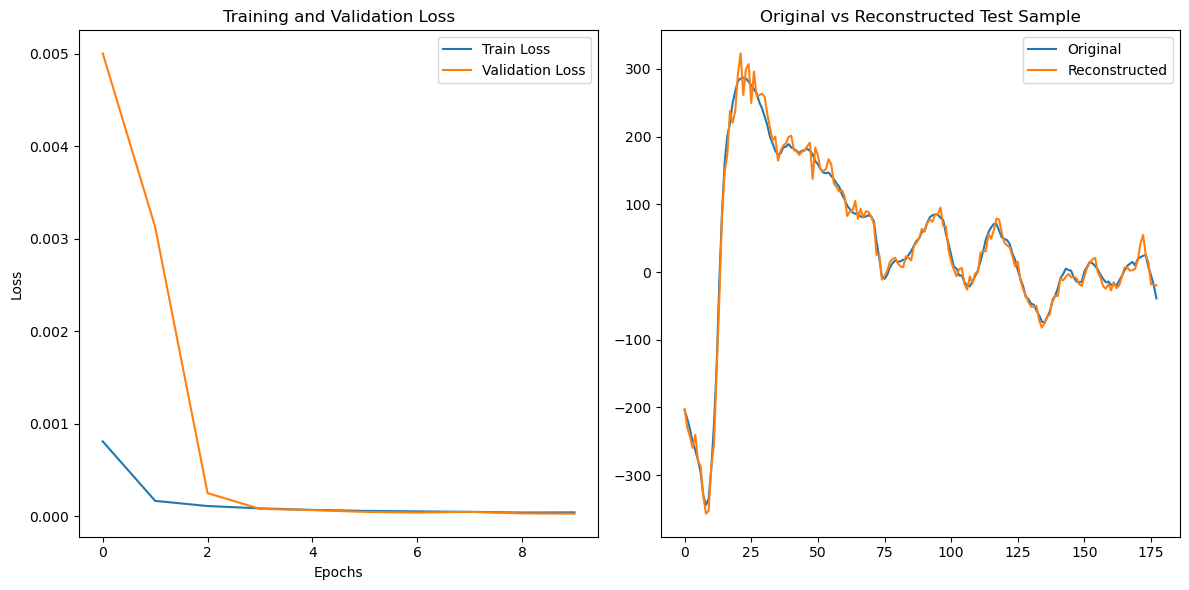

In [ ]:
autoencoder, encoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

In [ ]:
# Save the autoencoder model
autoencoder.save("autoencoder_model_no_dropout.h5")
print("Autoencoder model saved as 'autoencoder_model_no_dropout.h5'")

# Save the encoder model
# encoder.save("encoder_model.h5")
# print("Encoder model saved as 'encoder_model.h5'")

### 2. Dropout after 1D conv

#### 2.1 Dropout rate=0.25

Using device: /device:GPU:0
Epoch 1/10


2024-11-12 01:03:20.752922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-12 01:03:25.234434: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f66805fd110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-12 01:03:25.234462: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-12 01:03:25.283152: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-12 01:03:25.494632: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 34s 88ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 2/10
260/260 [==============================] - 20s 78ms/step - loss: 3.5084e-04 - val_loss: 0.0029
Epoch 3/10
260/260 [==============================] - 20s 78ms/step - loss: 2.3379e-04 - val_loss: 3.4399e-04
Epoch 4/10
260/260 [==============================] - 20s 78ms/step - loss: 1.7614e-04 - val_loss: 1.7086e-04
Epoch 5/10
260/260 [==============================] - 20s 78ms/step - loss: 1.4657e-04 - val_loss: 1.4933e-04
Epoch 6/10
260/260 [==============================] - 20s 79ms/step - loss: 1.1692e-04 - val_loss: 1.2757e-04
Epoch 7/10
260/260 [==============================] - 20s 78ms/step - loss: 1.0465e-04 - val_loss: 1.6206e-04
Epoch 8/10
260/260 [==============================] - 20s 79ms/step - loss: 9.6076e-05 - val_loss: 1.3784e-04
Epoch 9/10
260/260 [==============================] - 20s 78ms/step - loss: 8.6193e-05 - val_loss: 1.6567e-04
Epoch 10/10
35/35 [==============

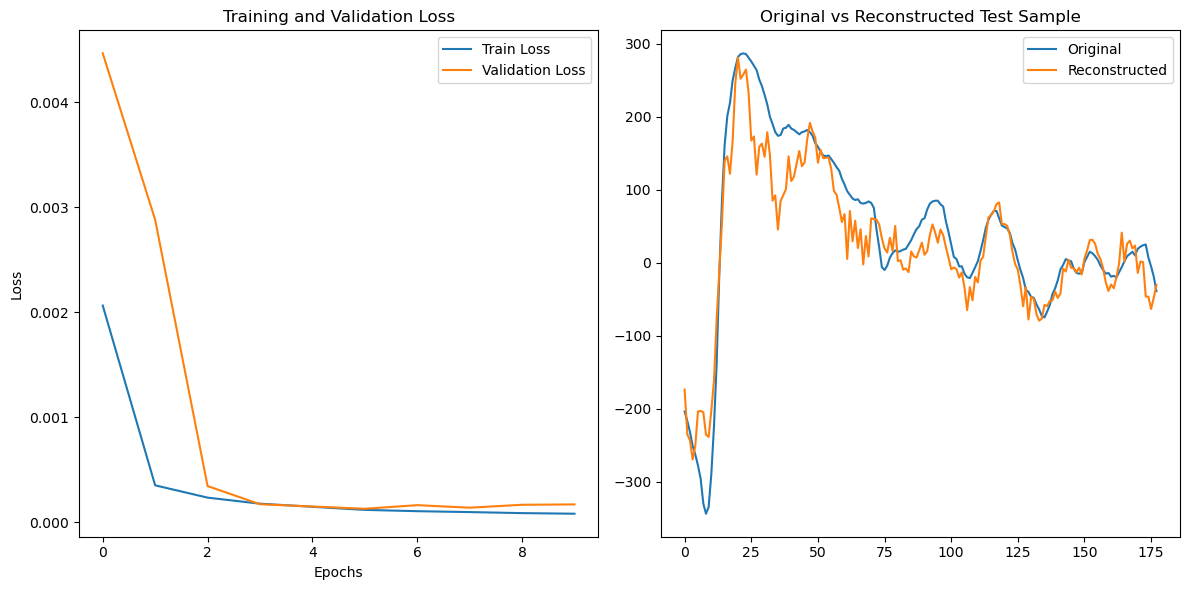

In [ ]:
autoencoder, _ = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0.25, two_d_dropout_rate=0)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

#### 2.2 Dropout rate=0.5

Using device: /device:GPU:0
Epoch 1/10
260/260 [==============================] - 24s 79ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 2/10
260/260 [==============================] - 20s 78ms/step - loss: 4.6930e-04 - val_loss: 0.0026
Epoch 3/10
260/260 [==============================] - 20s 78ms/step - loss: 3.1627e-04 - val_loss: 0.0010
Epoch 4/10
260/260 [==============================] - 20s 78ms/step - loss: 2.5517e-04 - val_loss: 7.0218e-04
Epoch 5/10
260/260 [==============================] - 20s 78ms/step - loss: 2.1773e-04 - val_loss: 7.3747e-04
Epoch 6/10
260/260 [==============================] - 20s 78ms/step - loss: 1.8650e-04 - val_loss: 8.1023e-04
Epoch 7/10
260/260 [==============================] - 20s 78ms/step - loss: 1.6033e-04 - val_loss: 8.2160e-04
Epoch 8/10
260/260 [==============================] - 20s 79ms/step - loss: 1.5792e-04 - val_loss: 8.0116e-04
Epoch 9/10
35/35 [==============================] - 1s 23ms/step - loss: 6.1012e-04
Test loss (reconstructio

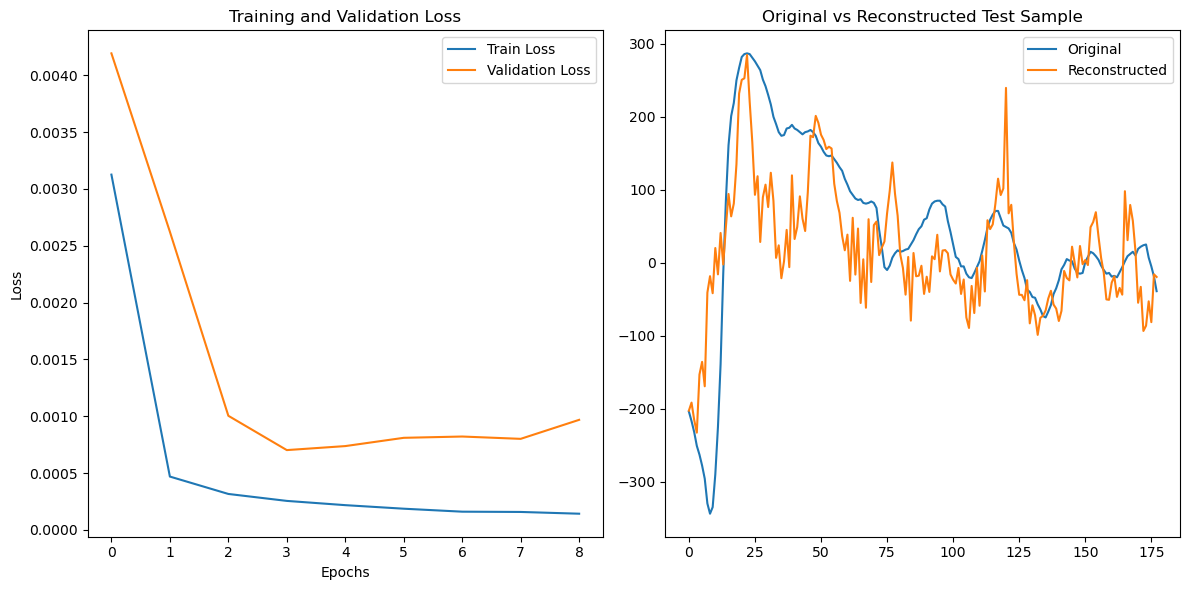

In [ ]:
autoencoder, _ = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0.5, two_d_dropout_rate=0)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

### 3. Dropout after 2D Conv

#### 3.1 Dropout rate=0.25

Using device: /device:GPU:0
Epoch 1/10


2024-10-27 06:38:49.995695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 [==============================] - 29s 103ms/step - loss: 0.0047 - val_loss: 0.0174
Epoch 2/10
260/260 [==============================] - 26s 102ms/step - loss: 6.5982e-04 - val_loss: 0.0130
Epoch 3/10
260/260 [==============================] - 26s 102ms/step - loss: 4.2042e-04 - val_loss: 6.3931e-04
Epoch 4/10
260/260 [==============================] - 26s 102ms/step - loss: 3.1411e-04 - val_loss: 1.0231e-04
Epoch 5/10
260/260 [==============================] - 27s 102ms/step - loss: 2.5155e-04 - val_loss: 9.7289e-05
Epoch 6/10
260/260 [==============================] - 27s 102ms/step - loss: 2.1015e-04 - val_loss: 8.7124e-05
Epoch 7/10
260/260 [==============================] - 27s 102ms/step - loss: 1.8543e-04 - val_loss: 7.2032e-05
Epoch 8/10
260/260 [==============================] - 27s 102ms/step - loss: 1.6178e-04 - val_loss: 7.2121e-05
Epoch 9/10
260/260 [==============================] - 27s 102ms/step - loss: 1.5094e-04 - val_loss: 8.4792e-05
Epoch 10/10
35/35 [=====

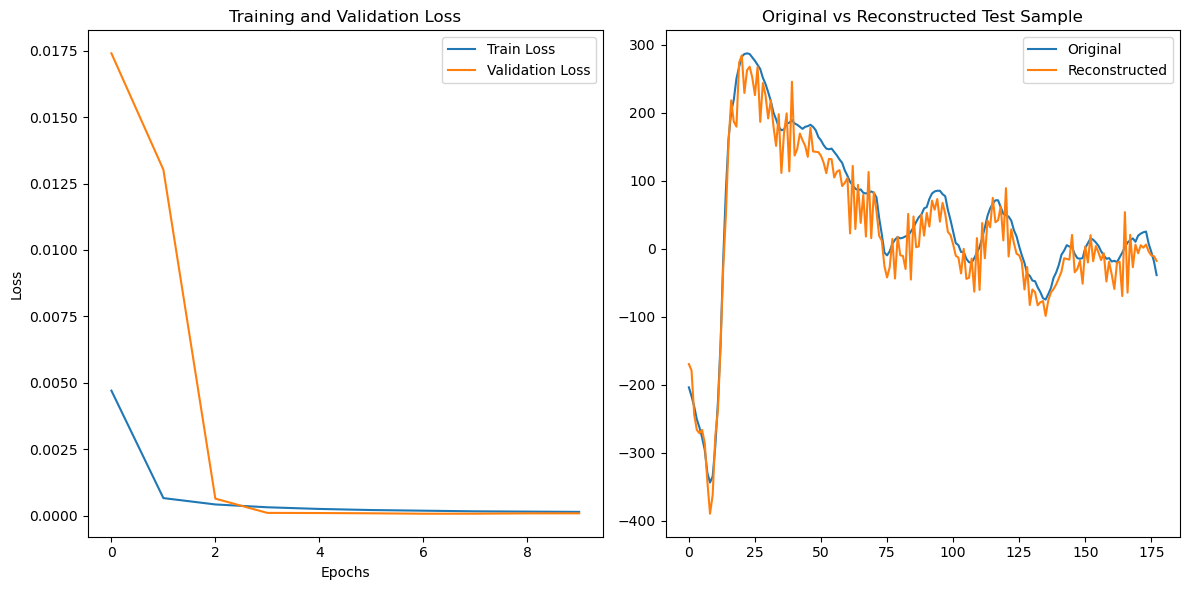

In [ ]:
autoencoder, _ = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.25)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

#### 3.2 Dropout rate=0.5

Using device: /device:GPU:0
Epoch 1/10


2024-10-27 06:43:20.478318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_23/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 [==============================] - 29s 103ms/step - loss: 0.0044 - val_loss: 0.0655
Epoch 2/10
260/260 [==============================] - 26s 102ms/step - loss: 6.3263e-04 - val_loss: 0.0227
Epoch 3/10
260/260 [==============================] - 27s 102ms/step - loss: 3.8051e-04 - val_loss: 9.6734e-04
Epoch 4/10
260/260 [==============================] - 27s 102ms/step - loss: 2.8078e-04 - val_loss: 1.3492e-04
Epoch 5/10
260/260 [==============================] - 27s 102ms/step - loss: 2.3445e-04 - val_loss: 1.1309e-04
Epoch 6/10
260/260 [==============================] - 27s 102ms/step - loss: 2.1417e-04 - val_loss: 2.0502e-04
Epoch 7/10
260/260 [==============================] - 27s 102ms/step - loss: 1.9667e-04 - val_loss: 1.0243e-04
Epoch 8/10
260/260 [==============================] - 27s 102ms/step - loss: 1.7434e-04 - val_loss: 1.0561e-04
Epoch 9/10
260/260 [==============================] - 27s 103ms/step - loss: 1.6224e-04 - val_loss: 9.4870e-05
Epoch 10/10
35/35 [=====

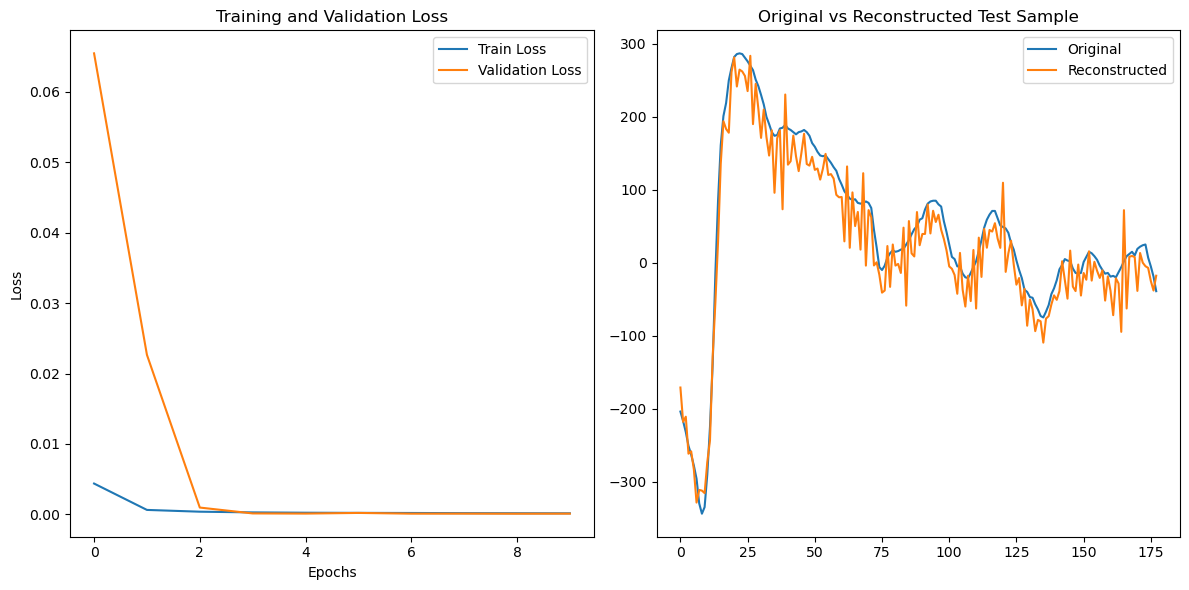

In [ ]:
autoencoder, _ = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.5)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

## II. Evaluation of Augmentation: Seizure Detection

We evaluate the effectiveness of data augmentation on the downstream task of seizure detection.

In [33]:
def evaluate_classification_metrics(y_true, y_pred, y_pred_prob):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision
    precision = precision_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if len(set(y_true)) > 1:
        # Check if ROC-AUC can be calculated (i.e., both classes are present)
        roc_auc = roc_auc_score(y_true, y_pred_prob)
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(y_true, y_pred)
    else:
        roc_auc = None  # Not computable, only one class in y_true
        kappa = None
    
    # Calculate metrics for seizure class (y_label=1)
    precision_seizure = precision_score(y_true, y_pred, pos_label=1)
    recall_seizure = recall_score(y_true, y_pred, pos_label=1)
    f1_seizure = f1_score(y_true, y_pred, pos_label=1)
    
    # Calculate metrics for non-seizure class (y_label=0)
    precision_non_seizure = precision_score(y_true, y_pred, pos_label=0)
    recall_non_seizure = recall_score(y_true, y_pred, pos_label=0)
    f1_non_seizure = f1_score(y_true, y_pred, pos_label=0)
    
    print(f'\nSeizure (y=1):')
    print(f'  Precision: {precision_seizure * 100:.2f} %')
    print(f'  Recall: {recall_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_seizure * 100:.2f} %')
    
    print(f'\nNon-Seizure (y=0):')
    print(f'  Precision: {precision_non_seizure * 100:.2f} %')
    print(f'  Recall: {recall_non_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_non_seizure * 100:.2f} %')
    
    # Print metrics
    print(f'\nOverall:')
    print(f'  Accuracy: {accuracy * 100:.2f} %')
    print(f'  Precision: {precision * 100:.2f} %')
    print(f'  Recall: {recall * 100:.2f} %')
    print(f'  F1 Score: {f1 * 100:.2f} %')
    if roc_auc is not None:
        print(f'  ROC-AUC: {roc_auc * 100:.2f} %')
    if kappa is not None:
        print(f'  Cohen\'s Kappa: {kappa * 100:.2f} %')

### Detection Model

- **Preprocessing**: No normalization. Since we are using challenging test cases, the scaler trained on the training dataset is completely different from the test set. Using the scaler to scale the test data would skew the results.
- **Feature**: Inception Nucleus.
- **Output Dimension**: 1 (Sigmoid activation).
- **Optimizer**: Adam.
- **Loss Function**: Cross-Entropy.
- **Early Stopping**: 5 epochs of patience.
- **Learning Rate**: 0.0001.

In [3]:
def InceptionNucleus(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_cnn(input_shape=(178, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12])

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x) # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten after 2D Convolutions
    x = Flatten()(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_eeg_cnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 178, 32)   │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 178, 32)   │        288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 178, 32)   │        416 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178, 96)   │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 178, 96,   │          0 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 178, 96,   │        640 │ reshape[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 178, 96,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 89, 48,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 273408)    │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │    546,818 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 548,578 (2.09 MB)

 Trainable params: 548,450 (2.09 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
def train_and_test_classification(X_train, y_train, X_test, y_test, lr_rate=0.0001, num_epochs=30):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create the model
    model = create_eeg_cnn(input_shape=(178, 1), num_classes=2)
    
    # Define the optimizer with a specific learning rate
    optimizer = Adam(learning_rate=lr_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model and store the training history
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  
        epochs=num_epochs, 
        batch_size=32,
        shuffle=True,
        callbacks=[early_stopping], 
        verbose=1 
    )
    
    # After training, evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    # Predict class probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities to binary class labels (assuming threshold 0.5)
    y_pred = (y_pred_prob[:, 1] > 0.5).astype(int)
    
    # Evaluate classification metrics using the provided function
    evaluate_classification_metrics(y_test, y_pred, y_pred_prob[:, 1])
    
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    
    # Plot training & validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


### Before augmentation

Epoch 1/30
260/260 [==============================] - 7s 20ms/step - loss: 5.9738 - accuracy: 0.9570 - val_loss: 10.2622 - val_accuracy: 0.9490
Epoch 2/30
260/260 [==============================] - 5s 19ms/step - loss: 4.9906 - accuracy: 0.9708 - val_loss: 2.0689 - val_accuracy: 0.9880
Epoch 3/30
260/260 [==============================] - 5s 19ms/step - loss: 3.4120 - accuracy: 0.9770 - val_loss: 3.6617 - val_accuracy: 0.9731
Epoch 4/30
260/260 [==============================] - 5s 19ms/step - loss: 1.5335 - accuracy: 0.9848 - val_loss: 2.1494 - val_accuracy: 0.9783
Epoch 5/30
260/260 [==============================] - 5s 19ms/step - loss: 2.1447 - accuracy: 0.9828 - val_loss: 1.1486 - val_accuracy: 0.9894
Epoch 6/30
260/260 [==============================] - 5s 19ms/step - loss: 1.0506 - accuracy: 0.9882 - val_loss: 0.9737 - val_accuracy: 0.9909
Epoch 7/30
260/260 [==============================] - 5s 19ms/step - loss: 0.8951 - accuracy: 0.9888 - val_loss: 1.5899 - val_accuracy: 0.989

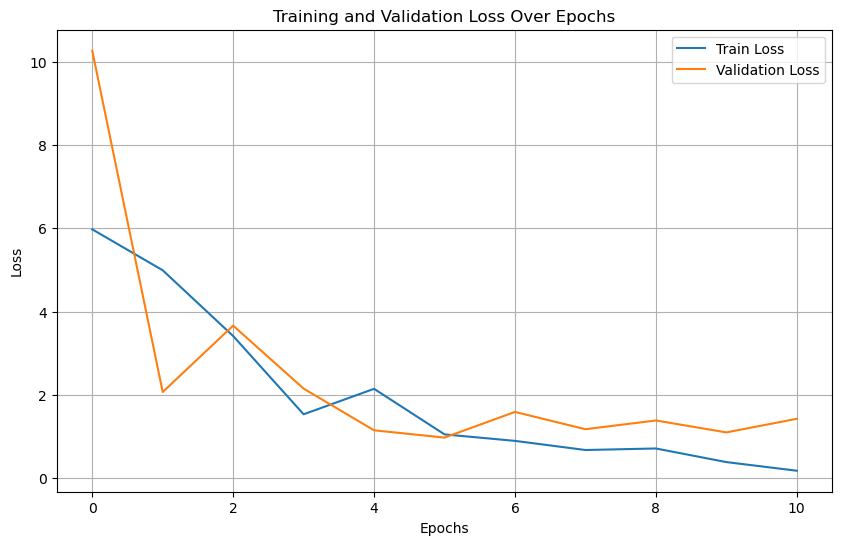

In [32]:
train_and_test_classification(X_train, y_train, X_test, y_test)

### After Augmentation
Feed reconstructed signal back to Autoencoder n times, to create n different augmented version.

In [ ]:
# Function to plot original vs augmented signals
def plot_original_vs_augmented(X_original, X_augmented, n_augmentations):
    plt.figure(figsize=(12, 8))
    
    for i in range(2):  # Plot for the first 2 samples
        plt.subplot(2, 1, i + 1)
        plt.plot(X_original[i].squeeze(), label='Original Signal', color='blue')  # Plot original signal
        
        # Plot each of the n_augmentations for the current original signal
        for aug_idx in range(n_augmentations):
            plt.plot(X_augmented[i][aug_idx].squeeze(), label=f'Augmented Signal {aug_idx+1}', linestyle='--')
        
        plt.title(f'Original vs Augmented Signal for Sample {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Function to manually augment a signal n times
def augment_signal_n_times(original_signal_scaled, autoencoder, n=5):
    augmented_signals = []
    current_signal_scaled = original_signal_scaled

    for _ in range(n):
        # Pass the current signal through the autoencoder to get a reconstruction
        reconstructed_scaled = autoencoder.predict(current_signal_scaled, verbose=0)
        
        # Append the augmented signal
        augmented_signals.append(reconstructed_scaled)
        
        # Feed back the perturbed signal for the next iteration
        current_signal_scaled = reconstructed_scaled
    
    # Return the list of augmented signals
    return np.array(augmented_signals)

Augmenting signal for sample 0
Augmenting signal for sample 1


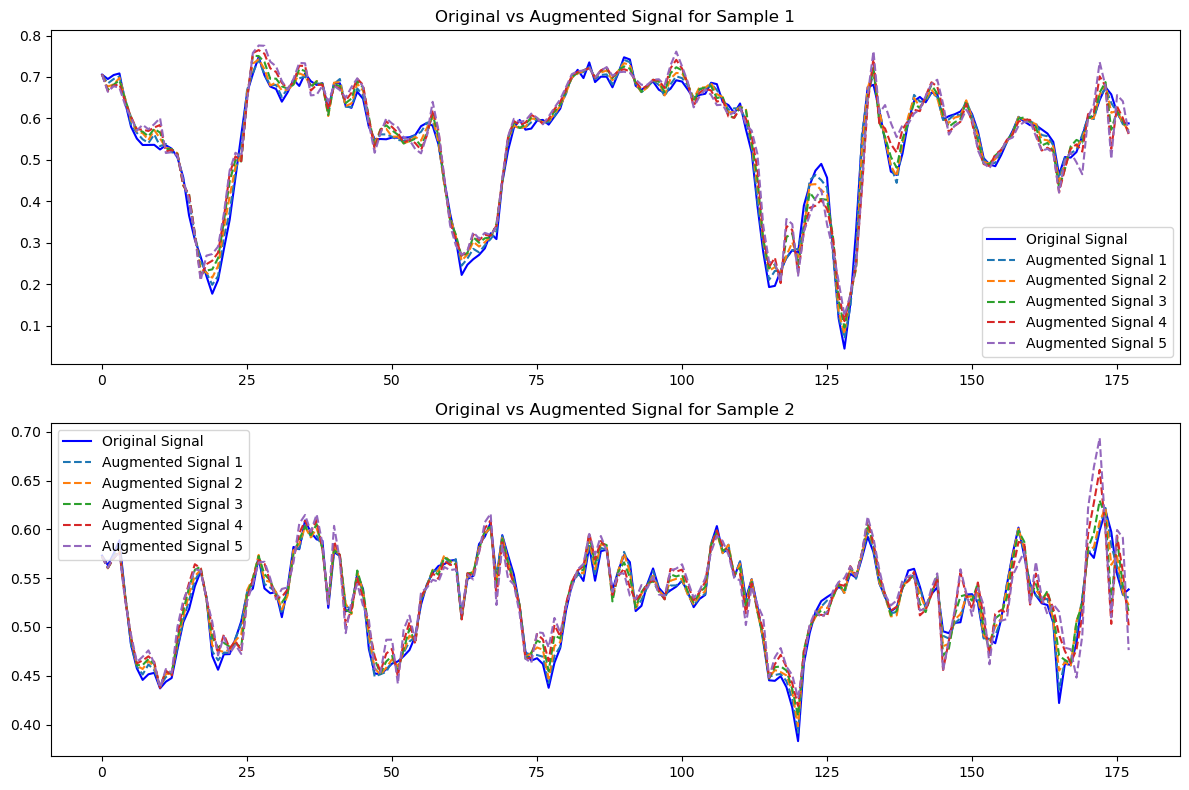

In [ ]:
# Example usage
n_augmentations = 5
first_two_augmented_signals = [[] for _ in range(2)]
for sample_idx in range(2):
    # Augment each signal 5 times
    augmented_signals = augment_signal_n_times(X_train_scaled[sample_idx:sample_idx+1], autoencoder, n=n_augmentations)
    first_two_augmented_signals[sample_idx] = np.array(augmented_signals)

plot_original_vs_augmented(X_train_scaled[:2], first_two_augmented_signals, n_augmentations)


### Augmented Dataset Generation

We use two approaches to generate augmented datasets:

1. **Balanced Training Dataset**:  
   Since the training dataset is imbalanced, with 80% non-seizure data and 20% seizure data, we augment only the seizure data. The augmentation continues until the training set contains an equal number of non-seizure and seizure samples.

2. **Augmenting the Entire Training Set**:  
   In this approach, we augment the entire training set by 5 times, increasing the variations in the dataset regardless of the labels.

#### Only augment the seizure label

In [ ]:
def generate_augmented_data_balanced(X_train, y_train, autoencoder):
    # Reshape X_train if needed to ensure 3D shape (e.g., (samples, 178, 1))
    if X_train.ndim == 2:
        X_train = X_train[..., np.newaxis]

    # Count the samples for each class
    class_counts = np.bincount(y_train)
    n_augmentations = max(class_counts) // min(class_counts) - 1
    print (n_augmentations)

    # Separate samples by class
    X_class_0 = X_train[y_train == 0]
    X_class_1 = X_train[y_train == 1]

    # Initialize lists to store augmented data and labels
    augmented_X = []
    augmented_y = []

    # Add original class 0 data
    for x in X_class_0:
        augmented_X.append(x.flatten())  # Flatten for saving as rows in CSV
        augmented_y.append(0)

    # Add original class 1 data
    for x in X_class_1:
        augmented_X.append(x.flatten())
        augmented_y.append(1)

    # Generate augmented samples for class 1
    for _ in tqdm(range(n_augmentations), desc="Generating augmentations"):
        augmented_class_1 = autoencoder.predict(X_class_1, verbose=0)
        
        # Ensure the augmented data has the correct shape
        for aug in augmented_class_1:
            augmented_X.append(aug.flatten())  # Flatten to save in CSV format
            augmented_y.append(1)

    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)
    augmented_df = pd.DataFrame(augmented_X)
    augmented_df['label'] = augmented_y
    print ("Label distribution in error cases (actual labels):\n", augmented_df['label'].value_counts())
    return augmented_X, augmented_y

In [ ]:
# Augment the dataset
X_train, y_train = generate_augmented_data_balanced(X_train, y_train, autoencoder)

3


Generating augmentations: 100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


label
0    44160
1    44160
Name: count, dtype: int64
Augmented data saved to data/augmented_training_data_balanced.csv


Epoch 1/30
412/412 [==============================] - 10s 21ms/step - loss: 2.4758 - accuracy: 0.6332 - val_loss: 1.3894 - val_accuracy: 0.7885
Epoch 2/30
412/412 [==============================] - 8s 19ms/step - loss: 0.6293 - accuracy: 0.8933 - val_loss: 0.7973 - val_accuracy: 0.9457
Epoch 3/30
412/412 [==============================] - 8s 19ms/step - loss: 0.1831 - accuracy: 0.9698 - val_loss: 0.1090 - val_accuracy: 0.9827
Epoch 4/30
412/412 [==============================] - 8s 19ms/step - loss: 0.0975 - accuracy: 0.9875 - val_loss: 0.0709 - val_accuracy: 0.9909
Epoch 5/30
412/412 [==============================] - 8s 20ms/step - loss: 0.0977 - accuracy: 0.9893 - val_loss: 0.0841 - val_accuracy: 0.9921
Epoch 6/30
412/412 [==============================] - 8s 20ms/step - loss: 0.1220 - accuracy: 0.9895 - val_loss: 0.1499 - val_accuracy: 0.9891
Epoch 7/30
412/412 [==============================] - 8s 19ms/step - loss: 0.1855 - accuracy: 0.9901 - val_loss: 0.3753 - val_accuracy: 0.980

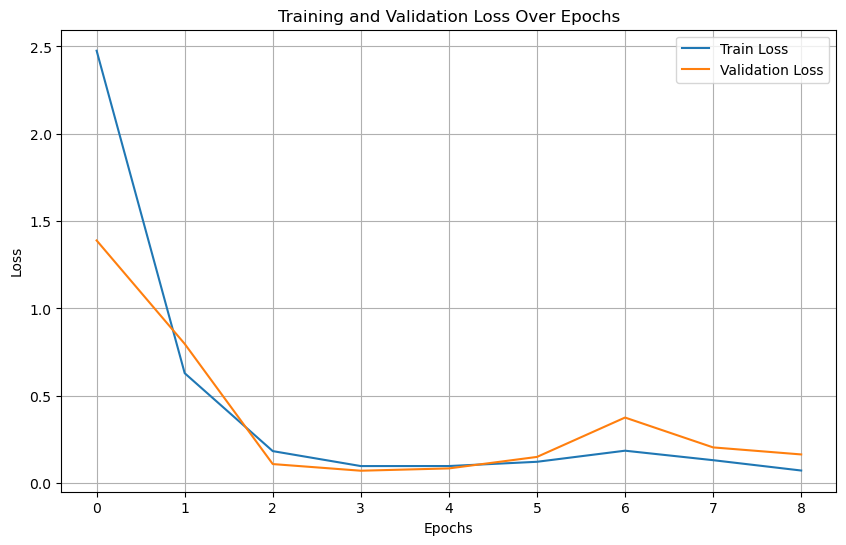

In [ ]:
# Evaluate on detection task
train_and_test_classification(X_train, y_train, X_test, y_test)

#### Augmenting the Entire Training Set

In [ ]:
def generate_augmented_data_entire_dataset(X_train, y_train, autoencoder, n_augmentations=5):
    # Reshape X_train if needed to ensure 3D shape (e.g., (samples, 178, 1))
    if X_train.ndim == 2:
        X_train = X_train[..., np.newaxis]

    # Initialize lists to store augmented data and labels
    augmented_X = []
    augmented_y = []

    # Add original data
    for x, y in zip(X_train, y_train):
        augmented_X.append(x.flatten())  # Flatten for saving as rows in CSV
        augmented_y.append(y)

    # Generate n_augmentations for each sample in X_train
    for _ in tqdm(range(n_augmentations), desc="Generating augmentations"):
        augmented_batch = autoencoder.predict(X_train, verbose=0)
        
        # Ensure the augmented data has the correct shape
        for aug, y in zip(augmented_batch, y_train):
            augmented_X.append(aug.flatten())  # Flatten to save in CSV format
            augmented_y.append(y)

    # Convert lists to arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)

    # Combine features and labels into a DataFrame
    augmented_df = pd.DataFrame(augmented_X)
    augmented_df['label'] = augmented_y
    print ("Label distribution in error cases (actual labels):\n", augmented_df['label'].value_counts())
    return augmented_X, augmented_y

In [ ]:
# Augment the dataset
X_train, y_train = generate_augmented_data_entire_dataset(X_train, y_train, autoencoder)

Generating augmentations: 100%|██████████| 5/5 [00:36<00:00,  7.37s/it]


label
0    50160
1    12168
Name: count, dtype: int64
Augmented data saved to data/augmented_training_data_unbalanced.csv


In [ ]:
# Evaluate on detection task
train_and_test_classification(X_train, y_train, X_test, y_test)